# Quantity base policy: price elasticity of carbon in EPPA

In [1]:
import pandas as pd
import pandas.io.excel
import numpy as np
import matplotlib.pyplot as plt
import datetime
import pytz
import os
import patsy #for spline regression
import scipy #for non-negative least square 
import scipy as sp 
from scipy import stats
from scipy.optimize import nnls
from numpy.linalg import inv #for matrix and statistics
import scipy as sp
import math
import statsmodels.api as sm
%matplotlib inline

In [2]:
#define main directory
mainDir = 'C:/Users/Admin/Documents/xxx/Profession/EnergyProject/EMF/CarbonElasticity'

As we modify codes as explained earlier, we can run multiple scenarios in EPPA by creating .cas file for cap price path and perturbation factor, then using a script that we wrote called 'batch_quantity-based.bat' in command prompt (see detail in the file) to run multiple scenarios. For EPPA, we need to run scenarios in one batch. That batch is one without any modification on carbon accounting. That is, only fossil fuel carbon is accounted for carbon tax.

We measure both price and quantities, then stack them together as a table.

In [3]:
color = 'green' #for EPPA

In [4]:
#define function to read price out (from previous note)
def pmeasure_eppa(CarbonAccounting, path, perturb):
    filename = 'y_res_test_policy_cap_' + path + '_' + perturb + '.xls'
    directory = mainDir + '/rawresult/' + 'EPPA' + '/' + CarbonAccounting + '/'+ 'test_policy_cap_' + path + '_' + perturb +'/'
    cbtax = pandas.io.excel.read_excel(directory + filename, sheetname="9c_price")
    cbtax = pd.DataFrame(cbtax.stack()).reset_index()
    cbtax.columns = ['region','year','price']
    cbtax['price'] = cbtax['price']/0.84628
    cbtax['year'] = list(cbtax['year'].map(lambda x: float(x)))
    p = cbtax[(cbtax.region=='USA')][['year','price']]
    p.set_index('year',inplace=True)
    p.columns = [perturb]
    return p;

#define function to read quantities out (from previous note)
def qmeasure_eppa(CarbonAccounting, path, perturb):
    filename = 'y_emit_test_policy_cap_' + path + '_' + perturb + '.xls'
    directory = mainDir + '/rawresult/' + 'EPPA' + '/' + CarbonAccounting + '/'+ 'test_policy_cap_' + path + '_' + perturb +'/'
    #total carbon emission
    CTOT = pandas.io.excel.read_excel(directory + filename, sheetname="5tot_co2")
    CTOT = pd.DataFrame(CTOT.stack()).reset_index()
    CTOT.columns = ['region','year','level']
    CTOT['level'] = CTOT['level'] #unit conversion to million ton of CO2 (MMtCO2)
    CTOT['year'] = list(CTOT['year'].map(lambda x: float(x)))
    
    #fossil + industry carbon emission
    CFI = pandas.io.excel.read_excel(directory + filename, sheetname="4fi_co2")
    CFI = pd.DataFrame(CFI.stack()).reset_index()
    CFI.columns = ['region','year','level']
    CFI['level'] = CFI['level'] #unit conversion to million ton of CO2 (MMtCO2)
    CFI['year'] = list(CFI['year'].map(lambda x: float(x)))

    #fossil carbon emission
    CFOS = pandas.io.excel.read_excel(directory + filename, sheetname="3fos_co2")
    CFOS = pd.DataFrame(CFOS.stack()).reset_index()
    CFOS.columns = ['region','year','level']
    CFOS['level'] = CFOS['level'] #unit conversion to million ton of CO2 (MMtCO2)
    CFOS['year'] = list(CFOS['year'].map(lambda x: float(x)))
     
    
    qUS_fos = CFOS[CFOS.region=='USA'][['year','level']]
    qUS_fos.set_index('year',inplace=True)
    qUS_fos.columns = [perturb]
    
    qglobal_fos = CFOS[['year','level']].groupby(['year'])['level'].agg({'level' : lambda x: np.sum(x)}).reset_index()
    qglobal_fos.set_index('year',inplace=True)
    qglobal_fos.columns = [perturb]
    
    qUS_fi = CFI[CFI.region=='USA'][['year','level']]
    qUS_fi.set_index('year',inplace=True)
    qUS_fi.columns = [perturb]
    
    qglobal_fi = CFI[['year','level']].groupby(['year'])['level'].agg({'level' : lambda x: np.sum(x)}).reset_index()
    qglobal_fi.set_index('year',inplace=True)
    qglobal_fi.columns = [perturb]
    
    qUS_tot = CTOT[CTOT.region=='USA'][['year','level']]
    qUS_tot.set_index('year',inplace=True)
    qUS_tot.columns = [perturb]
    
    qglobal_tot = CTOT[['year','level']].groupby(['year'])['level'].agg({'level' : lambda x: np.sum(x)}).reset_index()
    qglobal_tot.set_index('year',inplace=True)
    qglobal_tot.columns = [perturb]
    
    return qUS_tot, qglobal_tot, qUS_fi, qglobal_fi, qUS_fos, qglobal_fos;

## Default option: accounting fossil fuel carbon emission (FOS)

This is accounting fossil fuel carbon emission.

In [5]:
CarbonAccounting = 'quantity-based-fos' # 'price' vs. 'quantity' and tot' vs. 'fos'

def constructpq_table(path):
    ptable = pd.DataFrame()
    qUS_tot_table = pd.DataFrame()
    qglobal_tot_table = pd.DataFrame()
    qUS_fi_table = pd.DataFrame()
    qglobal_fi_table = pd.DataFrame()
    qUS_fos_table = pd.DataFrame()
    qglobal_fos_table = pd.DataFrame()
    for perturb in ['p085','p090','p095','p100','p105','p110','p115']:
        p = pmeasure_eppa(CarbonAccounting, path, perturb)
        ptable = pd.concat([ptable,p],axis=1)
        qUS_tot, qglobal_tot, qUS_fi, qglobal_fi, qUS_fos, qglobal_fos = qmeasure_eppa(CarbonAccounting, path, perturb)
        qUS_tot_table = pd.concat([qUS_tot_table,qUS_tot],axis=1)
        qglobal_tot_table = pd.concat([qglobal_tot_table,qglobal_tot],axis=1)
        qUS_fi_table = pd.concat([qUS_fi_table,qUS_fi],axis=1)
        qglobal_fi_table = pd.concat([qglobal_fi_table,qglobal_fi],axis=1)
        qUS_fos_table = pd.concat([qUS_fos_table,qUS_fos],axis=1)
        qglobal_fos_table = pd.concat([qglobal_fos_table,qglobal_fos],axis=1)
    return ptable, qUS_tot_table, qglobal_tot_table,qUS_fi_table, qglobal_fi_table, qUS_fos_table, qglobal_fos_table;

#p_cap600, qUS_tot_cap600, qglobal_tot_cap600, qUS_fi_cap600, qglobal_fi_cap600, qUS_fos_cap600, qglobal_fos_cap600 = constructpq_table('cap600')
p_cap500, qUS_tot_cap500, qglobal_tot_cap500, qUS_fi_cap500, qglobal_fi_cap500, qUS_fos_cap500, qglobal_fos_cap500 = constructpq_table('cap500')
p_cap400, qUS_tot_cap400, qglobal_tot_cap400, qUS_fi_cap400, qglobal_fi_cap400, qUS_fos_cap400, qglobal_fos_cap400 = constructpq_table('cap400')
p_cap300, qUS_tot_cap300, qglobal_tot_cap300, qUS_fi_cap300, qglobal_fi_cap300, qUS_fos_cap300, qglobal_fos_cap300 = constructpq_table('cap300')


Here we plot all types of carbon emission with different perturbations under different step caps.

C:\Users\Admin\Anaconda\lib\site-packages\matplotlib\figure.py:387: UserWarning: matplotlib is currently using a non-GUI backend, so cannot show the figure
  "matplotlib is currently using a non-GUI backend, "


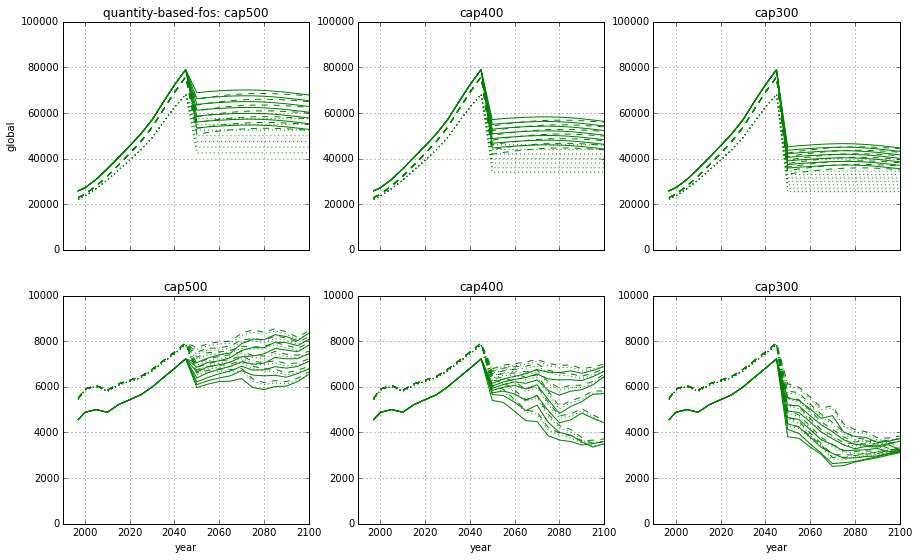

In [6]:
def q_plot(df1,df2,df3):
    for i in df1.columns.values:
        df1[i].plot(legend=False,color =color,linestyle='-')
    for i in df2.columns.values:
        df2[i].plot(legend=False,color =color,linestyle='--')
    for i in df3.columns.values:
        df3[i].plot(legend=False,color =color,linestyle=':')
    
fig = plt.figure(figsize=(15,9))

ax1  = fig.add_subplot(231)
q_plot(qglobal_tot_cap500,qglobal_fi_cap500,qglobal_fos_cap500)
ax1.set_title(CarbonAccounting +': cap500')
ax1.set_ylabel('global')
ax1.set_xlim(1990,2100)
ax1.set_ylim(0,100000)

ax1  = fig.add_subplot(232)
q_plot(qglobal_tot_cap400,qglobal_fi_cap400,qglobal_fos_cap400)
ax1.set_title('cap400')
ax1.set_xlim(1990,2100)
ax1.set_ylim(0,100000)

ax1  = fig.add_subplot(233)
q_plot(qglobal_tot_cap300,qglobal_fi_cap300,qglobal_fos_cap300)
ax1.set_title('cap300')
ax1.set_xlim(1990,2100)
ax1.set_ylim(0,100000)

ax1  = fig.add_subplot(234)
q_plot(qUS_tot_cap500,qUS_fi_cap500,qUS_fos_cap500)
ax1.set_title('cap500')
ax1.set_xlim(1990,2100)
ax1.set_ylim(0,10000)

ax1  = fig.add_subplot(235)
q_plot(qUS_tot_cap400,qUS_fi_cap400,qUS_fos_cap400)
ax1.set_title('cap400')
ax1.set_xlim(1990,2100)
ax1.set_ylim(0,10000)

ax1  = fig.add_subplot(236)
q_plot(qUS_tot_cap300,qUS_fi_cap300,qUS_fos_cap300)
ax1.set_title('cap300')
ax1.set_xlim(1990,2100)
ax1.set_ylim(0,10000)

fig.show()

(1990, 2100)

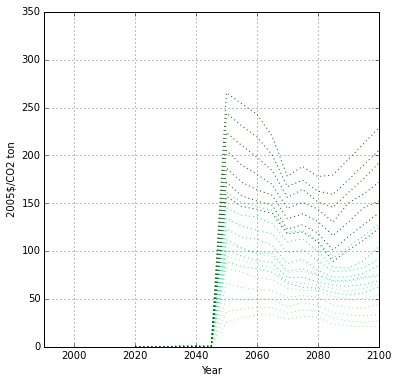

In [7]:

fig = plt.figure(figsize=(6,6))
ax1  = fig.add_subplot(111)
df1 = p_cap500
for i in df1.columns.values:
        df1[i].plot(legend=False,color ='lightgreen',linestyle=':')
df1 = p_cap400
for i in df1.columns.values:
        df1[i].plot(legend=False,color ='mediumspringgreen',linestyle=':')
df1 = p_cap300
for i in df1.columns.values:
        df1[i].plot(legend=False,color ='darkgreen',linestyle=':')
ax1.set_ylabel('2005$/CO2 ton')
ax1.set_ylim(0,350)
ax1.set_xlabel('Year')
ax1.set_xlim(1990,2100)

Since EPPA accounts only fossil fuel carbon emission, it makes sense to use fossil fuel carbon emission as $q$. Here we do regression between $\log{p}$ and $\log{q}$ to measure elasticity. Note that EPPA does not have foresight, so the carbon emission change sharply in 2050. Here we start measuring price elasticity of carbon emission in 2050.

In [9]:
def constructelasticity_table(p,q):
    elasticity_table = pd.DataFrame(columns = ('year','value','lower','upper'))
    yearlist = [2050, 2055, 2060, 2065, 2070, 2075, 2080, 2085, 2090, 2095, 2100]
    for i in range(0,len(yearlist)):
        x = np.log10(np.array(p[p.index==yearlist[i]]))[0]
        y = np.log10(np.array(q[q.index==yearlist[i]]))[0]
        X = sm.add_constant(x)
        model = sm.OLS(y, X)
        results = model.fit()
        elasticity_table.loc[i] = [yearlist[i], results.params[1]]+list(results.conf_int()[1])
    return elasticity_table;

In [10]:
def accumulated_elasticity(p,q):
    x = np.log10(np.array(p[p.index>=2050].sum(axis=0)))
    #y = np.log10(np.array(q[q.index==yearlist[i]]))[0]
    y = np.log10(np.array(q[q.index>=2050].sum(axis=0)))
    X = sm.add_constant(x)
    model = sm.OLS(y, X)
    results = model.fit()
    l = [results.params[1]]+list(results.conf_int()[1])
    return [l[0],(l[2]-l[1])*0.5];

(-4, 0)

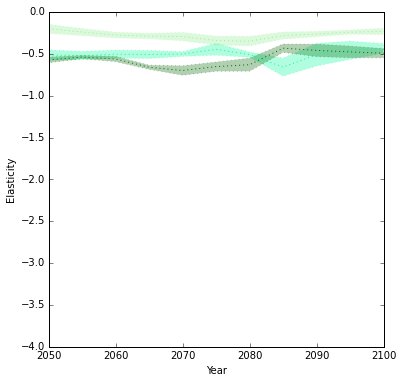

In [11]:
#fig = plt.figure(figsize=(3,8))

#ax1  = fig.add_subplot(211)
#fig = plt.figure(figsize=(3,8))
fig = plt.figure(figsize=(6,6))

ax1  = fig.add_subplot(111)
#ax1  = fig.add_subplot(211)

elasticity_table = constructelasticity_table(p_cap500,qglobal_fos_cap500)
ax1.plot(elasticity_table['year'],elasticity_table['value'],color='lightgreen',linestyle=':')
ax1.fill_between(np.array(list(elasticity_table['year'])),\
                 np.array(list(elasticity_table['lower'])),\
                 np.array(list(elasticity_table['upper'])), color='lightgreen',linestyle=':', alpha=0.3)   
elasticity_table = constructelasticity_table(p_cap400,qglobal_fos_cap400)
ax1.plot(elasticity_table['year'],elasticity_table['value'],color='mediumspringgreen',linestyle=':')
ax1.fill_between(np.array(list(elasticity_table['year'])),\
                 np.array(list(elasticity_table['lower'])),\
                 np.array(list(elasticity_table['upper'])), color='mediumspringgreen',linestyle=':', alpha=0.3)  
elasticity_table = constructelasticity_table(p_cap300,qglobal_fos_cap300)
ax1.plot(elasticity_table['year'],elasticity_table['value'],color='darkgreen',linestyle=':')
ax1.fill_between(np.array(list(elasticity_table['year'])),\
                 np.array(list(elasticity_table['lower'])),\
                 np.array(list(elasticity_table['upper'])), color='darkgreen',linestyle=':', alpha=0.3)          

ax1.set_ylabel('Elasticity')
ax1.set_xlabel('Year')
#ax1.set_title(CarbonAccounting +': global')
ax1.set_ylim(-4,0)

In [13]:
accumulated_elasticity(p_cap500,qglobal_fos_cap500)

[-0.26748485819253887, 0.041151176293088079]

In [14]:
accumulated_elasticity(p_cap400,qglobal_fos_cap400)

[-0.50507723699471718, 0.037273110391527142]

In [15]:
accumulated_elasticity(p_cap300,qglobal_fos_cap300)

[-0.55322701873393854, 0.035447449001485665]

## Alternative option: accounting all carbon emission (TOT)

This is total carbon emission. Confirmation is needed.

In [16]:
CarbonAccounting = 'quantity-based-tot' # 'price' vs. 'quantity' and tot' vs. 'fos'

#p_cap600, qUS_tot_cap600, qglobal_tot_cap600, qUS_fi_cap600, qglobal_fi_cap600, qUS_fos_cap600, qglobal_fos_cap600 = constructpq_table('cap600')
p_cap500, qUS_tot_cap500, qglobal_tot_cap500, qUS_fi_cap500, qglobal_fi_cap500, qUS_fos_cap500, qglobal_fos_cap500 = constructpq_table('cap500')
p_cap400, qUS_tot_cap400, qglobal_tot_cap400, qUS_fi_cap400, qglobal_fi_cap400, qUS_fos_cap400, qglobal_fos_cap400 = constructpq_table('cap400')
p_cap300, qUS_tot_cap300, qglobal_tot_cap300, qUS_fi_cap300, qglobal_fi_cap300, qUS_fos_cap300, qglobal_fos_cap300 = constructpq_table('cap300')


Here we plot all types of carbon emission with different perturbations under different step prices.

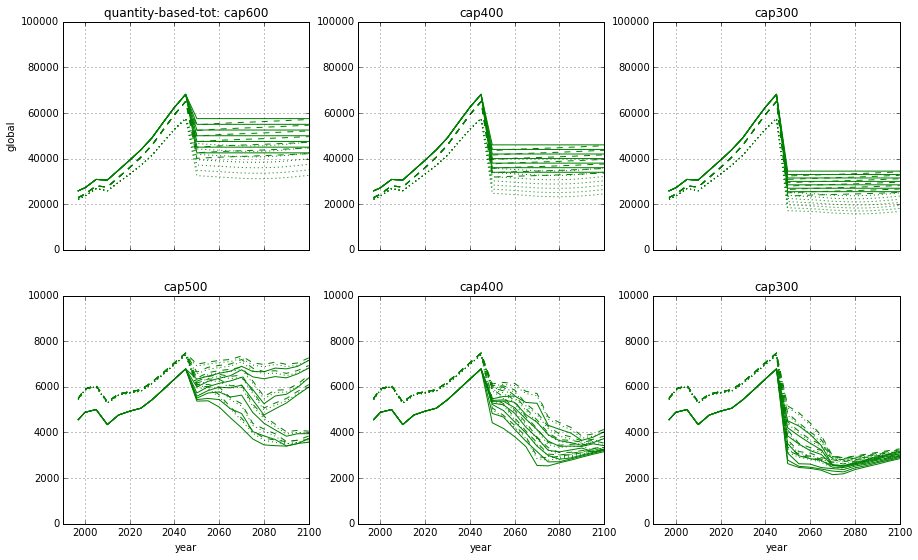

In [17]:
fig = plt.figure(figsize=(15,9))

ax1  = fig.add_subplot(231)
q_plot(qglobal_tot_cap500,qglobal_fi_cap500,qglobal_fos_cap500)
ax1.set_title(CarbonAccounting +': cap600')
ax1.set_ylabel('global')
ax1.set_xlim(1990,2100)
ax1.set_ylim(0,100000)

ax1  = fig.add_subplot(232)
q_plot(qglobal_tot_cap400,qglobal_fi_cap400,qglobal_fos_cap400)
ax1.set_title('cap400')
ax1.set_xlim(1990,2100)
ax1.set_ylim(0,100000)

ax1  = fig.add_subplot(233)
q_plot(qglobal_tot_cap300,qglobal_fi_cap300,qglobal_fos_cap300)
ax1.set_title('cap300')
ax1.set_xlim(1990,2100)
ax1.set_ylim(0,100000)

ax1  = fig.add_subplot(234)
q_plot(qUS_tot_cap500,qUS_fi_cap500,qUS_fos_cap500)
ax1.set_title('cap500')
ax1.set_xlim(1990,2100)
ax1.set_ylim(0,10000)

ax1  = fig.add_subplot(235)
q_plot(qUS_tot_cap400,qUS_fi_cap400,qUS_fos_cap400)
ax1.set_title('cap400')
ax1.set_xlim(1990,2100)
ax1.set_ylim(0,10000)

ax1  = fig.add_subplot(236)
q_plot(qUS_tot_cap300,qUS_fi_cap300,qUS_fos_cap300)
ax1.set_title('cap300')
ax1.set_xlim(1990,2100)
ax1.set_ylim(0,10000)

fig.show()

(1990, 2100)

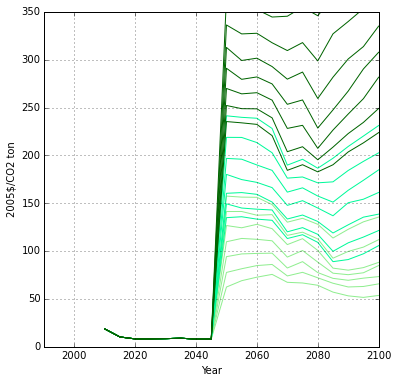

In [18]:

fig = plt.figure(figsize=(6,6))
ax1  = fig.add_subplot(111)
df1 = p_cap500
for i in df1.columns.values:
        df1[i].plot(legend=False,color ='lightgreen',linestyle='-')
df1 = p_cap400
for i in df1.columns.values:
        df1[i].plot(legend=False,color ='mediumspringgreen',linestyle='-')
df1 = p_cap300
for i in df1.columns.values:
        df1[i].plot(legend=False,color ='darkgreen',linestyle='-')
ax1.set_ylabel('2005$/CO2 ton')
ax1.set_ylim(0,350)
ax1.set_xlabel('Year')
ax1.set_xlim(1990,2100)

In the second batch (account total carbon in cap), it makes sense to use total fuel carbon emission as $q$. Here we do regression between $\log{p}$ and $\log{q}$ to measure elasticity. Note that EPPA has no perfect foresight, so the carbon emission changes in 2050. Here we start measuring price elasticity of carbon emission in 2050.


(-4, 0)

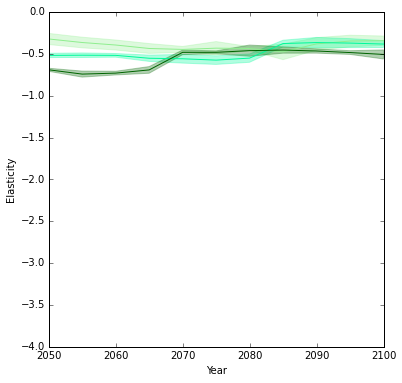

In [20]:
#fig = plt.figure(figsize=(3,8))
fig = plt.figure(figsize=(6,6))

ax1  = fig.add_subplot(111)
#ax1  = fig.add_subplot(211)

elasticity_table = constructelasticity_table(p_cap500,qglobal_tot_cap500)
ax1.plot(elasticity_table['year'],elasticity_table['value'],color='lightgreen')
ax1.fill_between(np.array(list(elasticity_table['year'])),\
                 np.array(list(elasticity_table['lower'])),\
                 np.array(list(elasticity_table['upper'])), color='lightgreen', alpha=0.3)   
elasticity_table = constructelasticity_table(p_cap400,qglobal_tot_cap400)
ax1.plot(elasticity_table['year'],elasticity_table['value'],color='mediumspringgreen')
ax1.fill_between(np.array(list(elasticity_table['year'])),\
                 np.array(list(elasticity_table['lower'])),\
                 np.array(list(elasticity_table['upper'])), color='mediumspringgreen', alpha=0.3)  
elasticity_table = constructelasticity_table(p_cap300,qglobal_tot_cap300)
ax1.plot(elasticity_table['year'],elasticity_table['value'],color='darkgreen')
ax1.fill_between(np.array(list(elasticity_table['year'])),\
                 np.array(list(elasticity_table['lower'])),\
                 np.array(list(elasticity_table['upper'])), color='darkgreen', alpha=0.3)          
ax1.set_ylabel('Elasticity')
ax1.set_xlabel('Year')
#ax1.set_title(CarbonAccounting +': global')
ax1.set_ylim(-4,0)


In [22]:
accumulated_elasticity(p_cap500,qglobal_tot_cap500)

[-0.39751490292018765, 0.034515847991549442]

In [23]:
accumulated_elasticity(p_cap400,qglobal_tot_cap400)

[-0.47214146008991165, 0.02839537284798152]

In [24]:
accumulated_elasticity(p_cap300,qglobal_fos_cap300)

[-0.71706210644452462, 0.012883703420461745]